In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import itertools

import preprocessing as pp
import utilities as u
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os
import umap
import umap.plot
import PlaceCellAnalysis as pc


# %matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\markp\anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df[(df['ImagingRegion']=='CA1' )|(df['ImagingRegion']=='')]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4343706','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sess = [5,5,5,3,5,2,4,4,4,4,4,4]
rare = [i<6 for i in range(len(mice))]
freq = [(1-r)>0 for r in rare]
print(rare,freq)

[True, True, True, True, True, True, False, False, False, False, False, False] [False, False, False, False, False, False, True, True, True, True, True, True]


In [5]:
def rep_dist(S_trial_mat,morphs,metric='cosine', pop=False,ftest = False):

    if pop:
        dist = np.zeros([1,morphs.shape[0]])
        S_trial_mat = S_trial_mat.reshape(S_trial_mat.shape[0],-1)
        S_trial_mat = S_trial_mat[:,:,np.newaxis]
        print(S_trial_mat.shape)
    else:
        dist = np.zeros((S_trial_mat.shape[-1],morphs.shape[0]))
    
    if metric in ["cosine","cos_llr"]:
            S_tmat = S_trial_mat/(np.linalg.norm(S_trial_mat,axis=1,ord=2,keepdims=True)+1E-8)
        
    for trial in range(morphs.shape[0]):
        mask0, mask1 = morphs==0, morphs==1
        if morphs[trial]==0:
            mask0[trial]=False
        elif morphs[trial]==1:
            mask1[trial]=False

        if metric == 'cosine':
            # calculate centroids
                
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0,keepdims=True), np.nanmean(S_trial_mat[mask1,:,:],axis=0,keepdims=True)
            centroid0=centroid0/(np.linalg.norm(centroid0,ord=2,axis=1,keepdims=True)+1E-8)
            centroid1=centroid1/(np.linalg.norm(centroid1,ord=2,axis=1,keepdims=True)+1E-8)

            # similarity to two centroids
            if pop:
#                 print(np.linalg.norm(centroid0))
                angle0,angle1 = np.dot(S_tmat[trial,:,:].T,centroid0.ravel()),np.dot(S_tmat[trial,:,:].T,centroid1.ravel())
#                 print(angle0,angle1)
            else:
                angle0,angle1 = np.diagonal(np.matmul(S_tmat[trial,:,:].T,np.squeeze(centroid0))),np.diagonal(np.matmul(S_tmat[trial,:,:].T,np.squeeze(centroid1)))
    #         # whole trial similarity fraction
            dist[:,trial] = np.squeeze(angle1/(angle0+angle1+1E-8))
    #         cd[:,trial]= np.diagonal(np.matmul(S_trial_mat[trial,:,:].T,cd_))
            
        elif metric == 'cos_llr':
             # calculate centroids
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0,keepdims=True), np.nanmean(S_trial_mat[mask1,:,:],axis=0,keepdims=True)
            centroid0=centroid0/(np.linalg.norm(centroid0,ord=2,axis=1,keepdims=True)+1E-8)
            centroid1=centroid1/(np.linalg.norm(centroid1,ord=2,axis=1,keepdims=True)+1E-8)
            
            # similarity to two centroids
            angle0,angle1 = np.diagonal(np.matmul(S_tmat[trial,:,:].T,centroid0)),np.diagonal(np.matmul(S_tmat[trial,:,:].T,centroid1))
            dist[:,trial]= np.log(angle1)-np.log(angle0)
        elif metric == "cd":
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0,keepdims=True), np.nanmean(S_trial_mat[mask1,:,:],axis=0,keepdims=True)
            
            cd = centroid0 - centroid1
            cd = cd/np.linalg.norm(cd,ord=2,keepdims=True,axis=1)
            dist[:,trial]= np.diagonal(np.matmul(S_trial_mat[trial,:,:].T,cd[0,:,:]))
        elif metric == "euclidean":
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0), np.nanmean(S_trial_mat[mask1,:,:],axis=0)
            
            dist0 = np.mean((S_trial_mat[trial,:,:]-centroid0)**2,axis=0)
            dist1 = np.mean((S_trial_mat[trial,:,:]-centroid1)**2,axis=0)
            
            dist[:,trial] = dist1/(dist0+dist1)
        elif metric == "euc_llr":
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0), np.nanmean(S_trial_mat[mask1,:,:],axis=0)
            
            dist0 = np.mean((S_trial_mat[trial,:,:]-centroid0)**2,axis=0)
            dist1 = np.mean((S_trial_mat[trial,:,:]-centroid1)**2,axis=0)
            dist[:,trial] = np.log(dist1)-np.log(dist0)
            
    if pop:  
        return dist
    else:
        
        if ftest:
            grandmean = np.nanmean(S_trial_mat,axis=0,keepdims=True)
            gm_dists = []
            for c in [0,.25,.5,.75,1]:
                gm_dists.append(np.nanmean((S_trial_mat[morphs==c,:,:]-grandmean)**2, axis=1))
            fvals = np.zeros((S_trial_mat.shape[-1],))
            pvals = np.zeros((S_trial_mat.shape[-1],))
            for cell in range(S_trial_mat.shape[-1]):   
                _f,_p = sp.stats.f_oneway(gm_dists[0][:,cell],gm_dists[1][:,cell],gm_dists[2][:,cell],gm_dists[3][:,cell],gm_dists[4][:,cell])
                fvals[cell] = _f
                pvals[cell]= _p
            return dist,fvals, pvals
        else:                
            mask0, mask1 = morphs==0, morphs==1
            centroid0, centroid1 = np.nanmean(S_trial_mat[mask0,:,:],axis=0), np.nanmean(S_trial_mat[mask1,:,:],axis=0)
            return dist, np.mean((centroid1-centroid0)**2,axis=0)
    
    
    
    

In [6]:
def single_sess_dist(sess,metric = "euclidean"):
    with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
    VRDat,S = data['VRDat'],data['S']
    S[np.isnan(S)]=0
    S = S/np.percentile(S,95,axis=0)
    trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
    S_trial_mat[np.isnan(S_trial_mat)]=0
    dist,centroid_diff = rep_dist(S_trial_mat,trial_info['morphs'],metric=metric,pop=False)
    
    return dist, centroid_diff, S_trial_mat, trial_info

# dist,centroid_diff = rep_dist(S_trial_mat,trial_info['morphs'],metric='euclidean',pop=False)
# dist,centroid_diff,trial_info = single_sess_dist(sess)
# print(centroid_diff)
# var = np.var(dist,axis=1)

In [7]:
def centroid_diff_perm_test(centroid_diff,S_trial_mat,trial_info,nperms=1000):
    centroid_diff_shuff = np.zeros([S_trial_mat.shape[-1],nperms])
    extreme_mask = (trial_info['morphs']==0) + (trial_info['morphs']==1)
    S_trial_mat_ext = S_trial_mat[extreme_mask,:,:]
    print(S_trial_mat_ext.shape)
    morphs_ext = trial_info['morphs'][extreme_mask]
    for p in range(nperms):
        _morph = morphs_ext[np.random.permutation(morphs_ext.shape[0])]
        centroid_diff_shuff[:,p] = np.mean((S_trial_mat_ext[_morph==0,:,:].mean(axis=0)-S_trial_mat_ext[_morph==1,:,:].mean(axis=0))**2,axis=0)
        
    return np.array(centroid_diff[:,np.newaxis]<centroid_diff_shuff,dtype=np.float).mean(axis=1)
    
def regress_distance(dist,morphs,x = np.linspace(-.1,1.1,num=50)) :
    dist_reg = np.zeros([dist.shape[0],x.shape[0]])
    for j in range(dist.shape[0]):
        model = sk.neighbors.KNeighborsRegressor(n_neighbors=10)
        model.fit(morphs[:,np.newaxis],dist[j,:])
        dist_reg[j,:]=model.predict(x[:,np.newaxis])
        
    return dist_reg

In [8]:
morphbin = np.linspace(-.11,1.11,num=11)
SM=[]
DIST_REG=[]
COSDIST_REG = []
mouselabel = []
rf_label = []
sess_ind = []
SIG_CELLS = {}
for m,mouse in enumerate(mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    SIG_CELLS[mouse]={}
    for ind in range(first_sess[m],df_mouse.shape[0]):
        sess = df_mouse.iloc[ind]

        dist, centroid_diff, S_trial_mat, trial_info= single_sess_dist(sess,metric='cosine')
        pval = centroid_diff_perm_test(centroid_diff,S_trial_mat,trial_info,nperms=1000)

        morphs = trial_info['morphs']+trial_info['wallJitter']
        morphOrder = np.argsort(morphs)
        sig_cells = pval<=.001
        S_tm_sig = S_trial_mat[:,:,sig_cells]
        
        dist_sig = dist[sig_cells,:]
        cd_sig = centroid_diff[sig_cells]

        dist_reg = regress_distance(dist_sig,morphs)
        DIST_REG.append(dist_reg)
        
        morphdig = np.digitize(morphs,morphbin)
        S_tm_bin = np.zeros([10,S_tm_sig.shape[1],S_tm_sig.shape[2]])
        for i in range(10):
            if (morphdig==i).sum()>0:
                S_tm_bin[i,:,:] = S_tm_sig[morphdig==i,:,:].mean(axis=0)
            

        SM.append(S_tm_bin.reshape(-1,S_tm_bin.shape[-1]).T)
        mouselabel.append(m*np.ones((S_tm_bin.shape[-1],)))
        rf_label.append(1*rare[m]*np.ones((S_tm_bin.shape[-1],)))
        sess_ind.append(ind*np.ones((S_tm_bin.shape[-1],)))
        SIG_CELLS[mouse][ind]=sig_cells

4139265.3
(60, 45, 1828)
(60, 45, 1904)
(60, 45, 1817)
(60, 45, 1708)
(60, 45, 1715)
4139265.4
(60, 45, 1632)
(60, 45, 1656)
(60, 45, 1515)
(60, 45, 1650)
(60, 45, 1498)
(60, 45, 1631)
4139265.5
(60, 45, 915)
(60, 45, 976)
(60, 45, 984)
(60, 45, 932)
(60, 45, 1047)
4222168.1
(52, 45, 919)
(52, 45, 1035)
(52, 45, 1074)
(52, 45, 940)
4343703.1
(52, 45, 1194)
4343706
(34, 45, 2652)
(34, 45, 1403)
(31, 45, 1617)
4222153.1
(38, 45, 301)
(39, 45, 273)
(37, 45, 237)
4222153.2
(48, 45, 2127)
(48, 45, 2149)
(42, 45, 2046)
(33, 45, 2006)
4222153.3
(32, 45, 161)
4222174.1
(28, 45, 1963)
(31, 45, 1998)
(34, 45, 2047)
(29, 45, 2117)
(35, 45, 1901)
4222154.1
(48, 45, 309)
(35, 45, 571)
(43, 45, 326)
(34, 45, 311)
(40, 45, 257)
4343702.1
(40, 45, 3313)
(29, 45, 2875)
(42, 45, 2746)


In [9]:
sm = np.concatenate(SM,axis=0)
dr = np.concatenate(DIST_REG,axis=0)
ml = np.concatenate(mouselabel)
rfl = np.concatenate(rf_label)
# sess_ind = np.concatenate(sess_ind)
print(sm.shape,ml.shape,rfl.shape)
print(rfl.sum(),rfl.shape[0]-rfl.sum())
print(np.unique(ml))

(18204, 450) (18204,) (18204,)
13833.0 4371.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]


(10, 45, 18204)


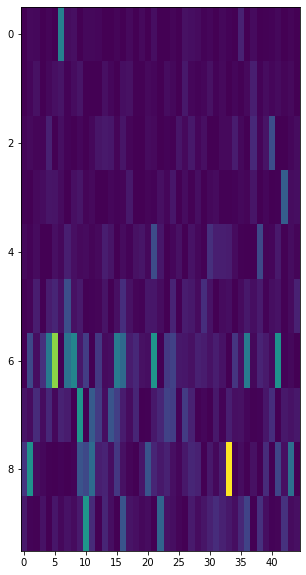

In [10]:
_sm = np.reshape(sm,(10,45,-1))
print(_sm.shape)

f,ax=plt.subplots(figsize=[5,10])
ax.imshow(_sm[:,:,12000],aspect='auto')

In [11]:
# for each permutation of mouse labels
diff_perms = []
iters =0
print(np.array(rare).sum())

for c, comb in enumerate(itertools.combinations(np.unique(ml),np.array(rare).sum())):
    if c>0:
        rare_mask = np.zeros(ml.shape)
        for _m_l  in comb:
#             print(_m_l)
            rare_mask += 1*(ml==_m_l)
        rare_mask = rare_mask>0
        diff_perms.append(dr[rare_mask,:].mean(axis=0)-dr[~rare_mask,:].mean(axis=0))
print(c)
diff_perms = np.array(diff_perms)
diff_min,diff_max = np.amin(diff_perms,axis=0),np.amax(diff_perms,axis=0)

6
923


In [12]:
sess_diff_perms = []

[False False False False False False False False False False False  True
  True False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]


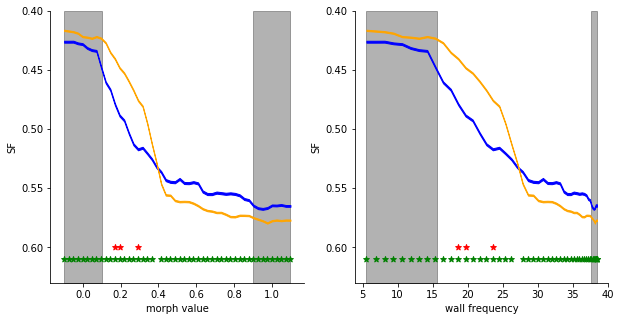

In [13]:
t,p = sp.stats.ttest_ind(dr[rfl==0,:],dr[rfl==1,:],axis=0)
# print(p)
# print(p<.05/50)
f,ax = plt.subplots(1,2,figsize=[10,5])
x = np.linspace(-.1,1.1,num=50)
mask = p<.05/50


ax[0].scatter(x[mask],.61*(x[mask]>-np.inf),color='green',marker='*')
mu,sem = dr[rfl==0,:].mean(axis=0),sp.stats.sem(dr[rfl==0,:],axis=0)
ax[0].fill_between(x,mu+sem,y2=mu-sem,color='blue')
mu,sem = dr[rfl==1,:].mean(axis=0),sp.stats.sem(dr[rfl==1,:],axis=0)
ax[0].fill_between(x,mu+sem,y2=mu-sem,color='orange')

ax[1].scatter(xfreq(x[mask]),.61*(x[mask]>-np.inf),color='green',marker='*')
mu,sem = dr[rfl==0,:].mean(axis=0),sp.stats.sem(dr[rfl==0,:],axis=0)
ax[1].fill_between(xfreq(x),mu+sem,y2=mu-sem,color='blue')
mu,sem = dr[rfl==1,:].mean(axis=0),sp.stats.sem(dr[rfl==1,:],axis=0)
ax[1].fill_between(xfreq(x),mu+sem,y2=mu-sem,color='orange')



diff = dr[rfl==1,:].mean(axis=0)-dr[rfl==0,:].mean(axis=0)
minmask = diff<diff_min
maxmask = diff>diff_max
mask = minmask+maxmask
print(minmask)
print(maxmask)
ax[0].scatter(x[mask],.6*(x[mask]>-np.inf),color='red',marker='*')
ax[0].fill_betweenx([.4,.63],-.1, .1,color='black',alpha=.3,zorder=0)
ax[0].fill_betweenx([.4,.63],.9,1.1,color='black',alpha=.3,zorder=0)

ax[1].scatter(xfreq(x[mask]),.6*(x[mask]>-np.inf),color='red',marker='*')
ax[1].fill_betweenx([.4,.63],xfreq(-.1), xfreq(.1),color='black',alpha=.3,zorder=0)
ax[1].fill_betweenx([.4,.63],xfreq(.9),xfreq(1.1),color='black',alpha=.3,zorder=0)


ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylim([.63,.4])
ax[1].set_ylim([.63,.4])

ax[0].set_xlabel('morph value')
ax[1].set_xlabel('wall frequency')
ax[0].set_ylabel('SF')
ax[1].set_ylabel('SF')
f.savefig("D://Morph_Results//figures//cos_dist_reg_differnce.png",format="png")
f.savefig("D://Morph_Results//figures//cos_dist_reg_differnce.pdf",format="pdf")

In [14]:


acc, perm_acc, pval = sk.model_selection.permutation_test_score(sk.linear_model.LogisticRegression(class_weight='balanced',solver='lbfgs') , dr, rfl,scoring='accuracy',n_jobs=-1,n_permutations=1000,cv=10)
print(acc,pval)

C:\Users\markp\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\markp\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\markp\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\markp\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\markp\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

KeyboardInterrupt: 

In [15]:
mapper = umap.UMAP(metric="correlation",n_neighbors=100,min_dist=.1).fit(dr)

KeyboardInterrupt: 

In [ ]:
# f,ax = plt.subplots()
# ax.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],c=ml)
print(rfl[:10],ml[:10])
print(mice[0])
f,ax = plt.subplots(figsize=[10,10])
ax.scatter(mapper.embedding_[rfl==0,0],mapper.embedding_[rfl==0,1],c='blue',s=100/rfl.shape[0]**.5)
ax.scatter(mapper.embedding_[rfl==1,0],mapper.embedding_[rfl==1,1],c='orange',s=100/rfl.shape[0]**.5)
ax.scatter(mapper.embedding_[rfl==1,0].mean(),mapper.embedding_[rfl==1,1].mean(),c='red')
ax.scatter(mapper.embedding_[rfl==0,0].mean(),mapper.embedding_[rfl==0,1].mean(),c='black')
f.savefig("D://Morph_Results//figures//UMAP_dist_reg.png",format="png")

# f,ax = plt.subplots(figsize=[10,10])
# ax.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],c=rfl,s=100/rfl.shape[0]**.5,cmap='jet')

In [ ]:
mapper = umap.UMAP(metric="correlation",n_neighbors=100,min_dist=.01,n_components=3).fit(sm)
# umap.plot.points(mapper)

In [ ]:
%matplotlib qt
f = plt.figure()

# frequent vs rare plot
ax1 = f.add_subplot(131,projection='3d')
ax1.scatter(mapper.embedding_[rfl==1,0],mapper.embedding_[rfl==1,1],mapper.embedding_[rfl==1,2],c='orange',s=100/rfl.shape[0]**.5,zorder=1)
ax1.scatter(mapper.embedding_[rfl==0,0],mapper.embedding_[rfl==0,1],mapper.embedding_[rfl==0,2],c='blue',s=100/rfl.shape[0]**.5,zorder=2)
ax1.grid(False)
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
# ax1.scatter(mapper.embedding_[rfl==1,0],mapper.embedding_[rfl==1,1],mapper.embedding_[rfl==1,2],c='orange',s=100/rfl.shape[0]**.5,zorder=1)

# color by morph value with highest activity rate
morphpref = np.argmax(sm.reshape(sm.shape[0],10,-1).mean(axis=-1),axis=-1)/10.
ax2 = f.add_subplot(132,projection='3d')
ax2.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=1-morphpref,cmap='cool',s=100/rfl.shape[0]**.5)
ax2.grid(False)
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False

# color by positin with highest activity rate
pospref = np.argmax(sm.reshape(sm.shape[0],10,-1).mean(axis=1),axis=-1)/45.
ax3 = f.add_subplot(133,projection='3d')
ax3.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=pospref,cmap='magma',s=100/rfl.shape[0]**.5)
ax3.grid(False)
ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False


def on_move(event):
    if event.inaxes == ax1:
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
        ax3.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
        ax3.view_init(elev=ax2.elev, azim=ax2.azim)
    elif event.inaxes == ax3:
        ax1.view_init(elev=ax3.elev, azim=ax3.azim)
        ax2.view_init(elev=ax3.elev, azim=ax3.azim)
    else:
        return
    f.canvas.draw_idle()

c1 = f.canvas.mpl_connect('motion_notify_event', on_move)

In [ ]:

sm_train,sm_test = sm[::2,:],sm[1::2,:]
rfl_train,rfl_test = rfl[::2],rfl[1::2]
train_mapper = umap.UMAP(metric="correlation",n_neighbors=100,min_dist=.01,n_components=3).fit(sm_train)
test_embedding = train_mapper.transform(sm_test)

test_mapper = umap.UMAP(metric="correlation",n_neighbors=100,min_dist=.01,n_components=3).fit(sm_test)
train_embedding = train_mapper.transform(sm_train)


In [ ]:
# %matplotlib inline
%matplotlib qt

f = plt.figure()
ax = f.add_subplot(221,projection='3d')

#
# f,ax = plt.subplots(figsize=[10,10])
ax.scatter(train_mapper.embedding_[rfl_train==0,0],train_mapper.embedding_[rfl_train==0,1],train_mapper.embedding_[rfl_train==0,2],c='blue',s=100/rfl.shape[0]**.5)
ax.scatter(train_mapper.embedding_[rfl_train==1,0],train_mapper.embedding_[rfl_train==1,1],train_mapper.embedding_[rfl_train==1,2],c='orange',s=100/rfl.shape[0]**.5)
ax.set_title("Train Odd")

ax = f.add_subplot(222,projection='3d')

#
# f,ax = plt.subplots(figsize=[10,10])
ax.scatter(test_embedding[rfl_test==0,0],test_embedding[rfl_test==0,1],test_embedding[rfl_test==0,2],c='blue',s=100/rfl.shape[0]**.5)
ax.scatter(test_embedding[rfl_test==1,0],test_embedding[rfl_test==1,1],test_embedding[rfl_test==1,2],c='orange',s=100/rfl.shape[0]**.5)
ax.set_title("Test Even")

ax = f.add_subplot(223,projection='3d')

#
# f,ax = plt.subplots(figsize=[10,10])
ax.scatter(train_embedding[rfl_train==0,0],train_embedding[rfl_train==0,1],train_embedding[rfl_train==0,2],c='blue',s=100/rfl.shape[0]**.5)
ax.scatter(train_embedding[rfl_train==1,0],train_embedding[rfl_train==1,1],train_embedding[rfl_train==1,2],c='orange',s=100/rfl.shape[0]**.5)
ax.set_title("Test Odd")

ax = f.add_subplot(224,projection='3d')

#
# f,ax = plt.subplots(figsize=[10,10])
ax.scatter(test_mapper.embedding_[rfl_test==0,0],test_mapper.embedding_[rfl_test==0,1],test_mapper.embedding_[rfl_test==0,2],c='blue',s=100/rfl.shape[0]**.5)
ax.scatter(test_mapper.embedding_[rfl_test==1,0],test_mapper.embedding_[rfl_test==1,1],test_mapper.embedding_[rfl_test==1,2],c='orange',s=100/rfl.shape[0]**.5)
ax.set_title("Train Even")


# f.show()

In [ ]:
clust_labels = sk.cluster.DBSCAN(min_samples=200).fit_predict(mapper.embedding_)
print(np.unique(clust_labels))
print((clust_labels==-1).sum())
c=1

In [ ]:
%matplotlib qt
# f,ax = plt.subplots(1,2,figsize=[10,5])
# ax[0].imshow(sm[clust_labels==0,:].mean(axis=0).reshape(10,-1)[1:,:],cmap='magma',aspect='auto')
# ax[1].imshow(sm[clust_labels==1,:].mean(axis=0).reshape(10,-1)[1:,:],cmap='magma',aspect='auto')

# f,ax = plt.subplots()
# ax.plot(sm[clust_labels==0,:].mean(axis=0).reshape(10,-1)[1:,:].mean(axis=1))
# ax.plot(sm[clust_labels==1,:].mean(axis=0).reshape(10,-1)[1:,:].mean(axis=1))

morphpref_clustlabels = 0*morphpref
morphpref_clustlabels[clust_labels==0]=np.mean(morphpref[clust_labels==0]) 
morphpref_clustlabels[clust_labels==1]=np.mean(morphpref[clust_labels==1])
f = plt.figure()
ax = f.add_subplot(111,projection='3d')
ax.scatter(mapper.embedding_[clust_labels>-1,0],mapper.embedding_[clust_labels>-1,1],mapper.embedding_[clust_labels>-1,2],c=1-morphpref_clustlabels[clust_labels>-1],cmap='cool',s=100/rfl.shape[0]**.5)

In [ ]:
k = 10
clust_results = {}
for c in [0,1]:
    clustmask = clust_labels==c
    clust_rfl = rfl[clustmask]
    clust_sm = sm[clustmask]
    
    clust_embedding = mapper.embedding_[clustmask,:]
    
    subclust_labels_unsort = sk.cluster.KMeans(n_clusters = k).fit_predict(clust_embedding)
    
    f = plt.figure()
    ax = f.add_subplot(111,projection='3d')
    ax.scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
    ax.scatter(clust_embedding[:,0],clust_embedding[:,1],clust_embedding[:,2],c=subclust_labels_unsort,cmap='hsv',s=100/clust_embedding.shape[0]**.5)
    
    # sort labels by position preference of cells in subcluster
    _lbls = np.unique(subclust_labels_unsort)
    print(_lbls)
    _lbls_pospref = np.zeros(_lbls.shape)
    for subclust_ind in range(_lbls.shape[0]):
        subclust_mask = subclust_labels_unsort==_lbls[subclust_ind]
        subclust_sm = clust_sm[subclust_mask,:]
        _lbls_pospref[subclust_ind]=np.argmax(subclust_sm.mean(axis=0).reshape(10,-1).mean(axis=0))*10
    subclust_labels = np.zeros(subclust_labels_unsort.shape)
    _lbls_sort_vec = _lbls[np.argsort(_lbls_pospref)]
    
    clust_results[c] = {}
    clust_results[c]['clustmask']=clustmask
    for _i,_ls in enumerate(_lbls_sort_vec.tolist()):
        subclust_labels[subclust_labels_unsort==_ls]=_i
    
    clust_results[c]['subclust_labels']=subclust_labels
    clust_results[c]['subclust_pospref']=np.sort(_lbls_pospref)
    for subclust_ind in _lbls.tolist():
        subclust_mask = subclust_labels==subclust_ind
        subclust_sm = clust_sm[subclust_mask,:]
        subclust_rfl = clust_rfl[subclust_mask]
        
        clust_results[c]['subclust_'+str(subclust_ind)]={}
        # visualization 
        subclust_mapper_vis = umap.UMAP(metric="correlation",n_neighbors=20,min_dist=.1,n_components=2).fit(subclust_sm)
        clust_results[c]['subclust_'+str(subclust_ind)]['mapper_vis']=subclust_mapper_vis
#         f,ax = plt.subplots()
#         ax.scatter(subclust_mapper_vis.embedding_[subclust_rfl==0,0],subclust_mapper_vis.embedding_[subclust_rfl==0,1],color='blue')
#         ax.scatter(subclust_mapper_vis.embedding_[subclust_rfl==1,0],subclust_mapper_vis.embedding_[subclust_rfl==1,1],color='orange')
        
        # classification
        subclust_mapper_class = umap.UMAP(metric="correlation",n_neighbors=20,min_dist=.1,n_components=10).fit(subclust_sm)
        clust_results[c]['subclust_'+str(subclust_ind)]['mapper_class']=subclust_mapper_class
        # leave one out cross-validation logistic regression
        acc, perm_acc, pval = sk.model_selection.permutation_test_score(sk.linear_model.LogisticRegression(class_weight='balanced',solver='lbfgs') , subclust_mapper_class.embedding_, subclust_rfl,scoring='accuracy',n_jobs=-1,n_permutations=100,cv=10)
        print(acc,pval)
        clust_results[c]['subclust_'+str(subclust_ind)]['acc']=acc
        clust_results[c]['subclust_'+str(subclust_ind)]['perm_acc']=perm_acc
        clust_results[c]['subclust_'+str(subclust_ind)]['pval'] = pval
        
        
        
    
    f = plt.figure()
    ax = f.add_subplot(111,projection='3d')
    ax.scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
#     ax.scatter(clust_embedding[:,0],clust_embedding[:,1],clust_embedding[:,2],c=subclust_pospref,cmap='magma',s=100/clust_embedding.shape[0]**.5)
    ax.scatter(clust_embedding[:,0],clust_embedding[:,1],clust_embedding[:,2],c=subclust_labels,cmap='magma',s=100/clust_embedding.shape[0]**.5)
    
    
    


In [ ]:
# frequent vs rare plot
%matplotlib qt
f,axes = plt.figure(),[[]]*4
axes[0] = f.add_subplot(221,projection='3d')
axes[0].scatter(mapper.embedding_[rfl==0,0],mapper.embedding_[rfl==0,1],mapper.embedding_[rfl==0,2],c='blue',s=100/rfl.shape[0]**.5)
axes[0].scatter(mapper.embedding_[rfl==1,0],mapper.embedding_[rfl==1,1],mapper.embedding_[rfl==1,2],c='orange',s=100/rfl.shape[0]**.5)

# %matplotlib qt
# color by morph value with highest activity rate
axes[1] = f.add_subplot(222,projection='3d')
axes[1].scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=1-morphpref,cmap='cool',s=100/rfl.shape[0]**.5)

# %matplotlib qt
# color by positin with highest activity rate
axes[2] = f.add_subplot(223,projection='3d')
axes[2].scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=pospref,cmap='magma',s=100/rfl.shape[0]**.5)
# %matplotlib qt
#color by cluster
axes[3] = f.add_subplot(224,projection='3d')
clustmask = clust_results[0]['clustmask']
axes[3].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[0]['subclust_labels'],cmap='hsv',s=100/clust_embedding.shape[0]**.5)
clustmask = clust_results[1]['clustmask']
axes[3].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[1]['subclust_labels'],cmap='rainbow',s=100/clust_embedding.shape[0]**.5)


for ax in axes:
    ax.grid(False)
    ax.xaxis.pane.fill=False
    ax.yaxis.pane.fill=False
    ax.zaxis.pane.fill=False
    
def on_move(event):
    if event.inaxes == axes[0]:
        axes[1].view_init(elev=axes[0].elev,azim=axes[0].azim)
        axes[2].view_init(elev=axes[0].elev,azim=axes[0].azim)
        axes[3].view_init(elev=axes[0].elev,azim=axes[0].azim)
    elif event.inaxes == axes[1]:
        axes[0].view_init(elev=axes[1].elev,azim=axes[1].azim)
        axes[2].view_init(elev=axes[1].elev,azim=axes[1].azim)
        axes[3].view_init(elev=axes[1].elev,azim=axes[1].azim)
    elif event.inaxes == axes[2]:
        axes[0].view_init(elev=axes[2].elev,azim=axes[2].azim)
        axes[1].view_init(elev=axes[2].elev,azim=axes[2].azim)
        axes[3].view_init(elev=axes[2].elev,azim=axes[2].azim)
    elif event.inaxes == axes[3]:
        axes[0].view_init(elev=axes[3].elev,azim=axes[3].azim)
        axes[1].view_init(elev=axes[3].elev,azim=axes[3].azim)
        axes[2].view_init(elev=axes[3].elev,azim=axes[3].azim)
    else:
        return
    f.canvas.draw_idle()

c1 = f.canvas.mpl_connect('motion_notify_event', on_move)

In [ ]:
# frequent vs rare plot
%matplotlib qt
f,axes = plt.figure(),[[]]*8
axes[0] = f.add_subplot(331,projection='3d')
axes[0].scatter(mapper.embedding_[rfl==0,0],mapper.embedding_[rfl==0,1],mapper.embedding_[rfl==0,2],c='blue',s=100/rfl.shape[0]**.5)
axes[0].scatter(mapper.embedding_[rfl==1,0],mapper.embedding_[rfl==1,1],mapper.embedding_[rfl==1,2],c='orange',s=100/rfl.shape[0]**.5)
# axes[0].grid(False)

# %matplotlib qt
# color by morph value with highest activity rate
axes[1] = f.add_subplot(332,projection='3d')
axes[1].scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=1-morphpref,cmap='cool',s=100/rfl.shape[0]**.5)

# %matplotlib qt
# color by positin with highest activity rate
axes[2] = f.add_subplot(333,projection='3d')
axes[2].scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],mapper.embedding_[:,2],c=pospref,cmap='magma',s=100/rfl.shape[0]**.5)
# %matplotlib qt
#color by cluster
axes[3] = f.add_subplot(334,projection='3d')
axes[3].scatter(mapper.embedding_[clust_labels>-1,0],mapper.embedding_[clust_labels>-1,1],mapper.embedding_[clust_labels>-1,2],c=1-morphpref_clustlabels[clust_labels>-1],cmap='cool',s=100/rfl.shape[0]**.5)
# %matplotlib qt
# plot subclusters with hsv colormap
axes[4] = f.add_subplot(335,projection='3d')
clustmask = clust_results[0]['clustmask']
axes[4].scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
axes[4].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[0]['subclust_labels'],cmap='hsv',s=100/clust_embedding.shape[0]**.5)
# %matplotlib qt
axes[5] = f.add_subplot(336,projection='3d')
clustmask = clust_results[1]['clustmask']
axes[5].scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
axes[5].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[1]['subclust_labels'],cmap='hsv',s=100/clust_embedding.shape[0]**.5)

# %matplotlib qt
# plot subclusters with position colormap
axes[6] = f.add_subplot(337,projection='3d')
clustmask = clust_results[0]['clustmask']
axes[6].scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
axes[6].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[0]['subclust_labels'],cmap='magma',s=100/clust_embedding.shape[0]**.5)
# %matplotlib qt
axes[7] = f.add_subplot(338,projection='3d')
clustmask = clust_results[1]['clustmask']
axes[7].scatter(mapper.embedding_[~clustmask,0],mapper.embedding_[~clustmask,1],mapper.embedding_[~clustmask,2],c='black',s=100/rfl.shape[0]**.5,alpha=.001)
axes[7].scatter(mapper.embedding_[clustmask,0],mapper.embedding_[clustmask,1],mapper.embedding_[clustmask,2],c=clust_results[1]['subclust_labels'],cmap='magma',s=100/clust_embedding.shape[0]**.5)


# axes = np.array(axes)
for ax in axes:
    ax.grid(False)
    ax.xaxis.pane.fill=False
    ax.yaxis.pane.fill=False
    ax.zaxis.pane.fill=False
    
def on_move(event):
    for ax in axes:
        if event.inaxes == ax:
            for ax2 in axes:
                if ax2!= ax:
                    ax2.view_init(elev=ax.elev, azim=ax.azim)
        else:
            return
    f.canvas.draw_idle()
c1 = f.canvas.mpl_connect('motion_notify_event', on_move)

In [ ]:
if np.array([False, False, True]).any():
    print('true')

In [ ]:
%matplotlib inline
import matplotlib.gridspec as gridspec
for c in [0,1]:
    for subclust_ind in range(10):
        f = plt.figure(figsize=[20,10])
#         f,ax = plt.subplots(2,4,figsize=[20,10])
        gs = gridspec.GridSpec(2,5)
        embedding = clust_results[c]['subclust_'+str(subclust_ind)]['mapper_vis'].embedding_
        subclust_rfl = rfl[clust_results[c]['clustmask']]
        subclust_rfl = subclust_rfl[clust_results[c]['subclust_labels']==subclust_ind]
        
        ax = f.add_subplot(gs[:2,:2])
        ax.scatter(embedding[subclust_rfl==0,0],embedding[subclust_rfl==0,1],c='blue',marker='o',s=500/rfl.shape[0]**.5)
        ax.scatter(embedding[subclust_rfl==1,0],embedding[subclust_rfl==1,1],c='orange',marker='o',s=500/rfl.shape[0]**.5)
        f.suptitle("clust %i, subclust %i, spatial_pref %f, classification acc %f, pval %f" %(c, subclust_ind,clust_results[c]['subclust_pospref'][subclust_ind],clust_results[c]['subclust_'+str(subclust_ind)]['acc'],clust_results[c]['subclust_'+str(subclust_ind)]['pval']))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        
        subclust_sm = sm[clust_results[c]['clustmask']]
        subclust_sm = subclust_sm[clust_results[c]['subclust_labels']==subclust_ind]
        subclust_sm = subclust_sm/np.mean(subclust_sm,axis=1,keepdims=True)
#         subclust_sm = sp.stats.zscore(subclust_sm,axis=1)
        
        trialmat_rare,trialmat_freq = np.mean(subclust_sm[subclust_rfl==1],axis=0).reshape(10,-1)[1:,:],np.mean(subclust_sm[subclust_rfl==0],axis=0).reshape(10,-1)[1:,:]
        trialmat_rare_n, trialmat_freq_n = trialmat_rare/np.linalg.norm(trialmat_rare,ord=2,axis=1,keepdims=True),trialmat_freq/np.linalg.norm(trialmat_freq,ord=2,axis=1,keepdims=True)
        ax = f.add_subplot(gs[0,2])
        im = ax.imshow(trialmat_rare,aspect='auto',cmap='magma',extent=[0,450,1,0],vmin=.5,vmax=5)
        plt.colorbar(im,ax=ax)
        ax = f.add_subplot(gs[1,2])
        im = ax.imshow(np.dot(trialmat_rare_n,trialmat_rare_n.T),cmap='cividis',extent=[0,1,1,0],vmin=0.8,vmax=1)
        plt.colorbar(im,ax=ax)
        ax = f.add_subplot(gs[0,3])
        im = ax.imshow(trialmat_freq,aspect='auto',cmap='magma',extent=[0,450,1,0],vmin=.5,vmax=5)
        plt.colorbar(im,ax=ax)
        ax = f.add_subplot(gs[1,3])
        im = ax.imshow(np.dot(trialmat_freq_n,trialmat_freq_n.T),cmap='cividis',extent=[0,1,1,0],vmin=0.8,vmax=1)
        plt.colorbar(im,ax=ax)
        simmat_rare = np.dot(trialmat_rare_n,trialmat_rare_n.T)
        simmat_freq = np.dot(trialmat_freq_n,trialmat_freq_n.T)
        ax = f.add_subplot(gs[1,4])
        im = ax.imshow(simmat_rare-simmat_freq,cmap='seismic',vmin=-.1,vmax=.1)
        plt.colorbar(im,ax=ax)

        diff = trialmat_rare-trialmat_freq
        ax = f.add_subplot(gs[0,4])
        im = ax.imshow(diff,cmap='seismic',aspect='auto',vmin=-2,vmax=2)
        plt.colorbar(im,ax=ax)
            
#         f.savefig("D:\\Morph_Results\\figures\\UMAP_clustres\\clust%i_subclust%i.png" %(c,subclust_ind),format='png')
#         f.savefig("D:\\Morph_Results\\figures\\UMAP_clustres\\clust%i_subclust%i.pdf" %(c,subclust_ind),format='pdf')

dict_keys(['clustmask', 'subclust_labels', 'subclust_pospref', 'subclust_0', 'subclust_1', 'subclust_2', 'subclust_3', 'subclust_4', 'subclust_5', 'subclust_6', 'subclust_7', 'subclust_8', 'subclust_9'])


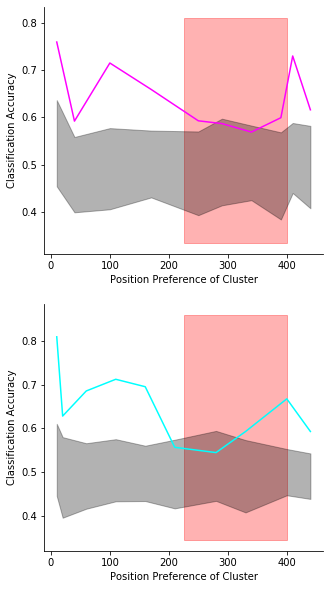

In [23]:
acc0,acc1 = [],[]
perm0,perm1 = [],[]
pospref0,pospref1=[],[]
for i in range(10):
    acc0.append(clust_results[0]['subclust_'+str(i)]['acc'])
    acc1.append(clust_results[1]['subclust_'+str(i)]['acc'])
    _p0 = clust_results[0]['subclust_'+str(i)]['perm_acc']
    perm0.append([np.amin(_p0),np.amax(_p0)])
    _p1 = clust_results[1]['subclust_'+str(i)]['perm_acc']
    perm1.append([np.amin(_p1),np.amax(_p1)])
    pospref0.append(clust_results[0]['subclust_pospref'][i])
    pospref1.append(clust_results[1]['subclust_pospref'][i])
f,ax = plt.subplots(2,1,figsize=[5,10])
ax[0].plot(pospref0,acc0,color = plt.cm.cool(1.))
ax[1].plot(pospref1,acc1,color = plt.cm.cool(0.))
perm0 = np.array(perm0)
perm1 = np.array(perm1)
# print(pospref0,pospref1)
ax[0].fill_between(pospref0,perm0[:,0],y2=perm0[:,1],alpha=.3,color='black')
ax[1].fill_between(pospref1,perm1[:,0],y2=perm1[:,1],alpha=.3,color='black')
print(clust_results[0].keys())
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_xlabel('Position Preference of Cluster')
ax[1].set_xlabel('Position Preference of Cluster')
ax[0].set_ylabel('Classification Accuracy')
ax[1].set_ylabel('Classification Accuracy')

ax[0].fill_betweenx([np.amin(perm0)-.05,np.amax(acc0)+.05],225,400,color='red',alpha=.3,zorder=-10)
ax[1].fill_betweenx([np.amin(perm1)-.05,np.amax(acc1)+.05],225,400,color='red',alpha=.3,zorder=-10)

f.savefig("D:\\Morph_Results\\figures\\UMAP_clustres\\class_acc.png",format='png')
f.savefig("D:\\Morph_Results\\figures\\UMAP_clustres\\class_acc.pdf",format='pdf')

In [25]:
with open("D:\\Morph_Results\\UMAPClustResults.pkl","wb") as f:
    pickle.dump({'clust_results':clust_results,'S_mats':sm,'mapper':mapper,'pospref':pospref,'morphpref':morphpref,'dist_reg':dr,'mouse_label':ml,'rare_freq_label':rfl,'sess_ind':sess_ind,'SIG_CELLS':SIG_CELLS},f)
    

In [16]:
with open("D:\\Morph_Results\\UMAPClustResults.pkl","rb") as f:
    results = pickle.load(f)
    

In [17]:
print(results.keys())

dict_keys(['clust_results', 'S_mats', 'mapper', 'pospref', 'morphpref', 'dist_reg', 'mouse_label', 'rare_freq_label', 'sess_ind', 'SIG_CELLS'])


In [18]:
clust_results, sm,mapper,pospref,morphpref,dr,ml,rfl,sess_ind,SIG_CELLS = results['clust_results'],results['S_mats'],results['mapper'], results['pospref'], results['morphpref'], results['dist_reg'],results['mouse_label'],results['rare_freq_label'], results['sess_ind'], results['SIG_CELLS']

In [80]:
trial_mat_cache={}

[  2  11  15  21  24  34  86  90  99 150 160 180 183 278 289 342 347 377
 419 437 444 447 466 472 489 494 500 521 583 616 623 624 627 634 681 693
 705 719 774] (39,)


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


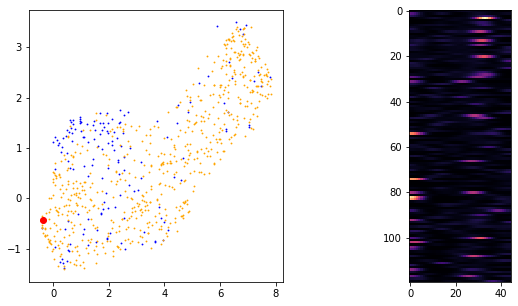

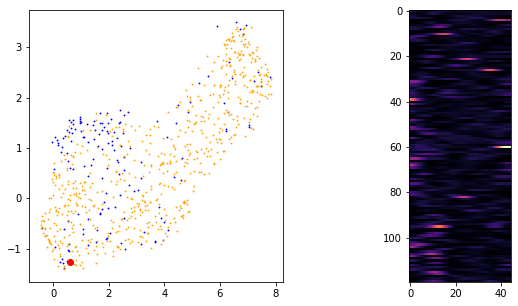

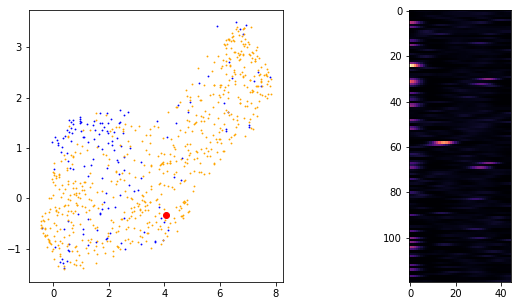

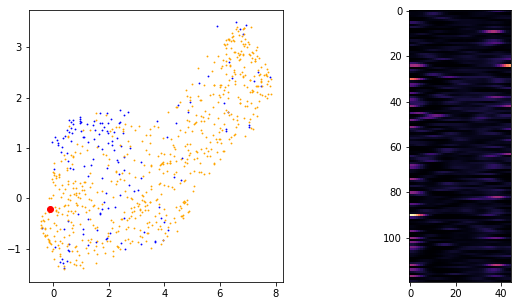

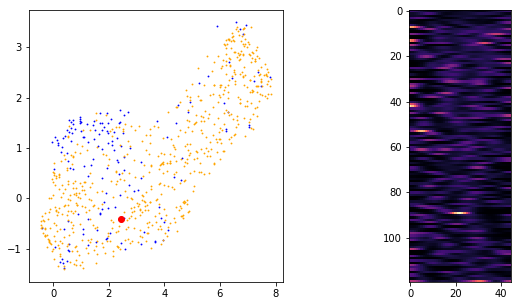

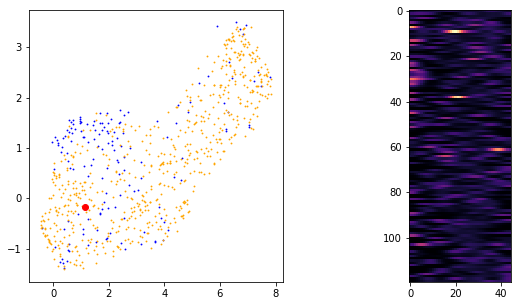

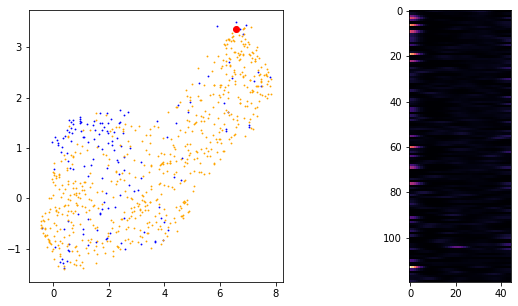

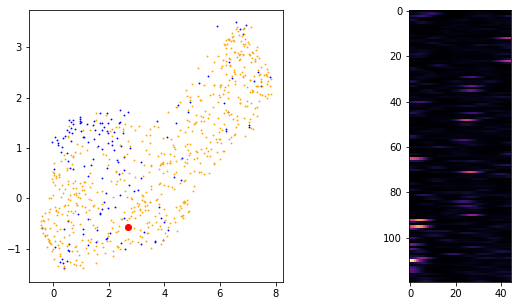

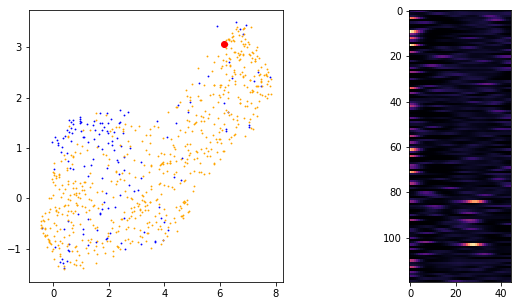

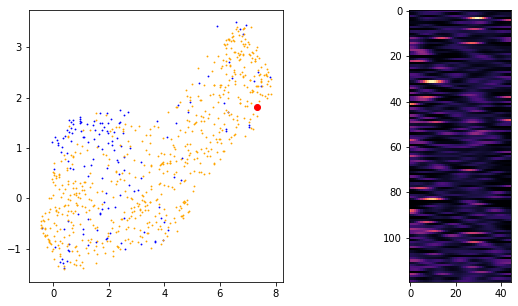

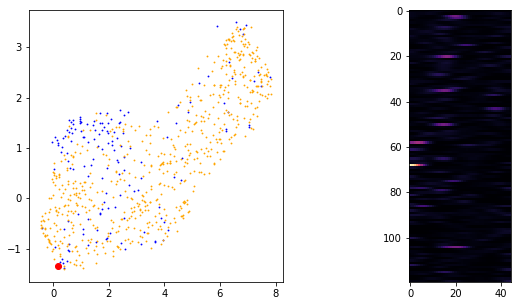

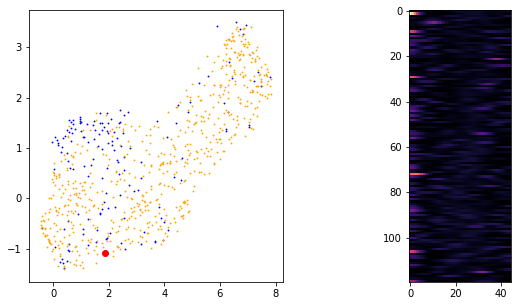

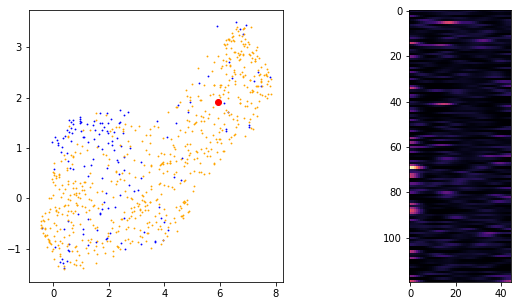

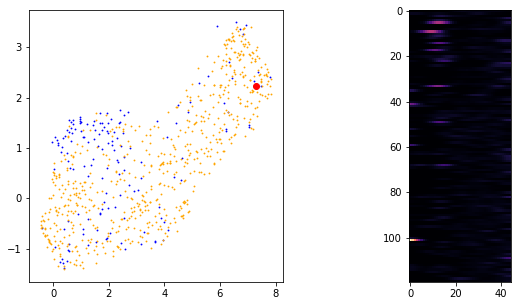

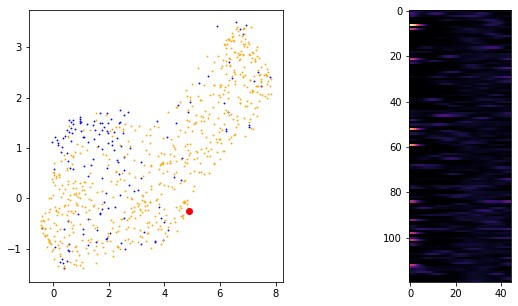

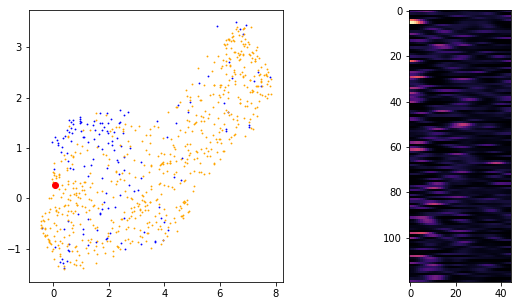

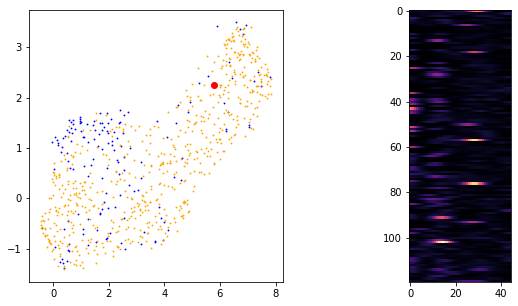

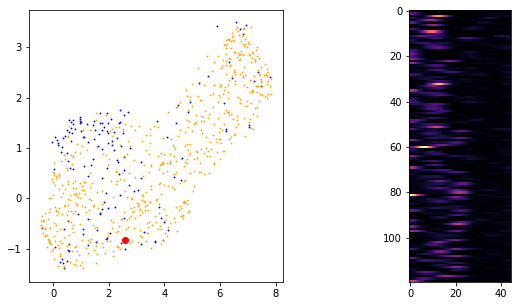

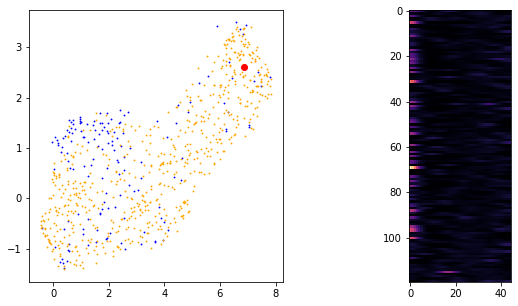

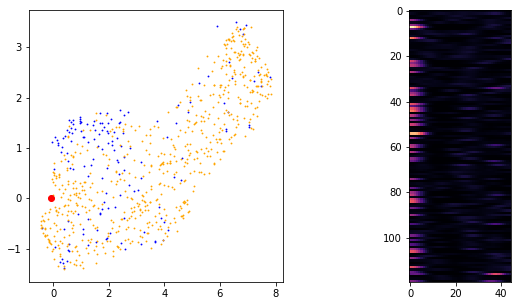

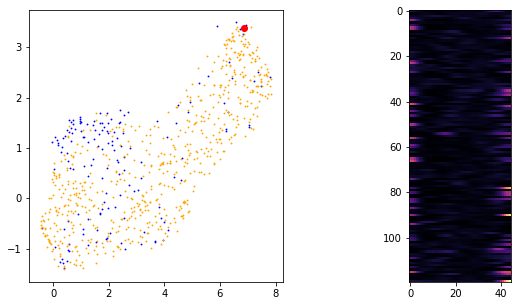

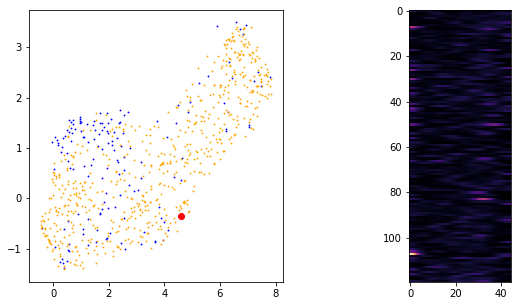

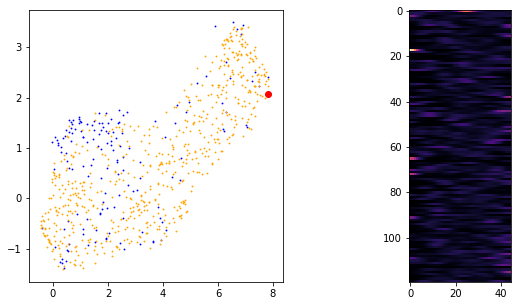

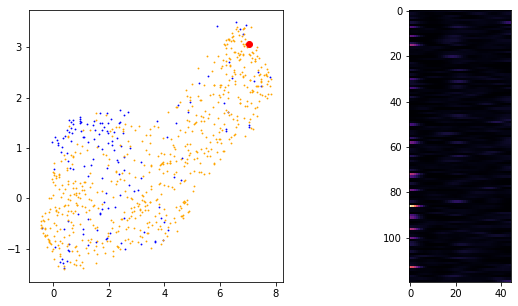

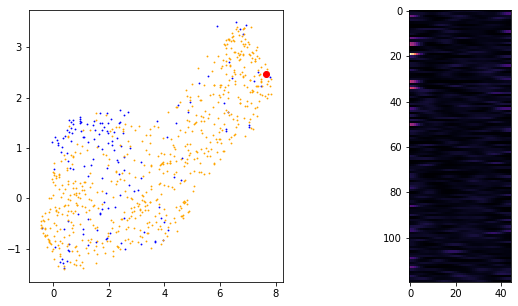

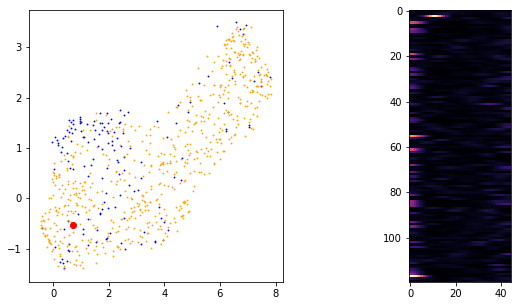

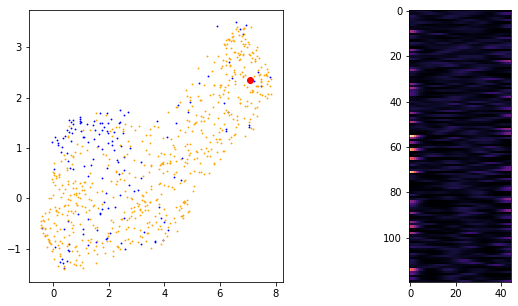

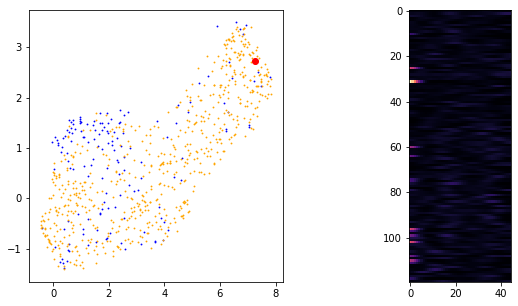

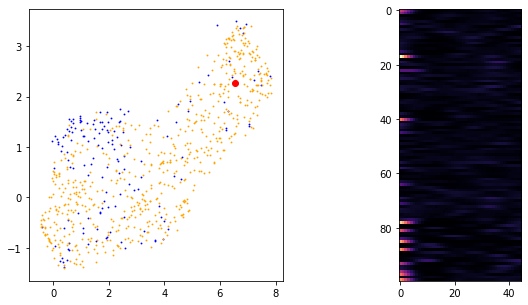

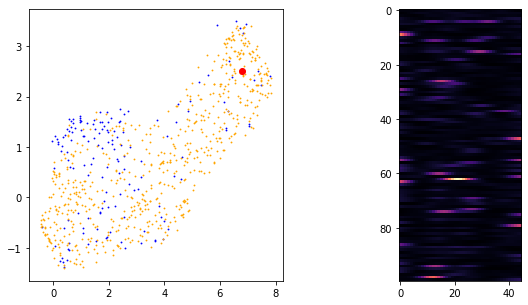

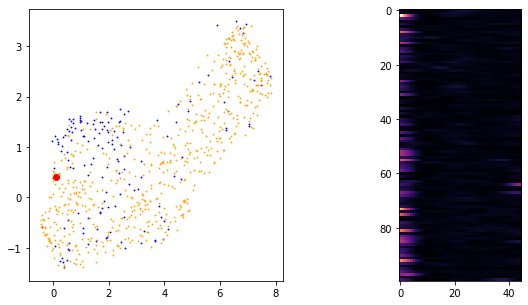

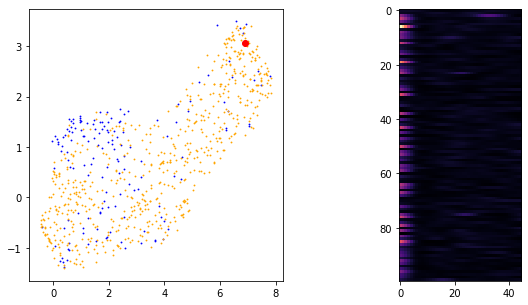

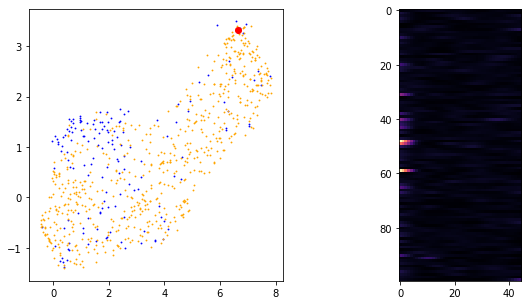

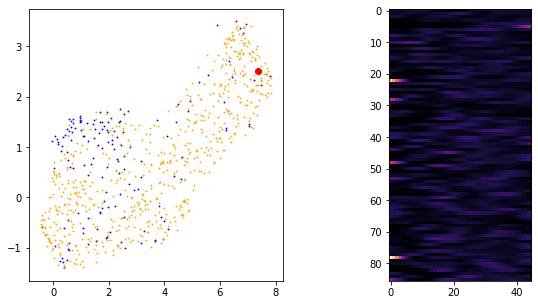

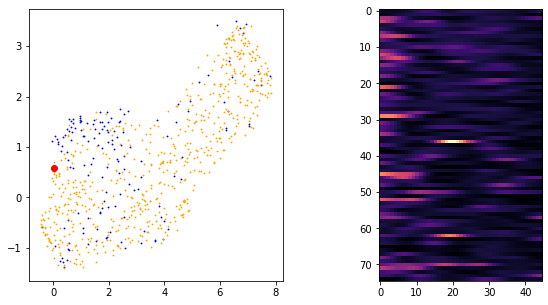

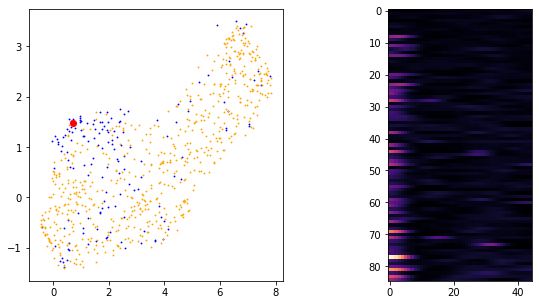

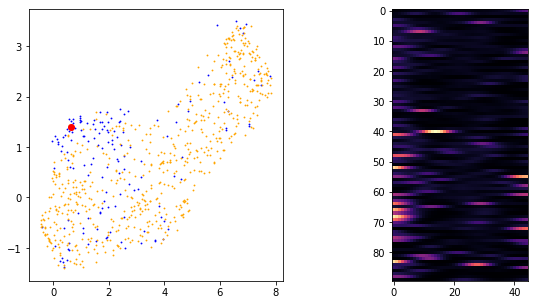

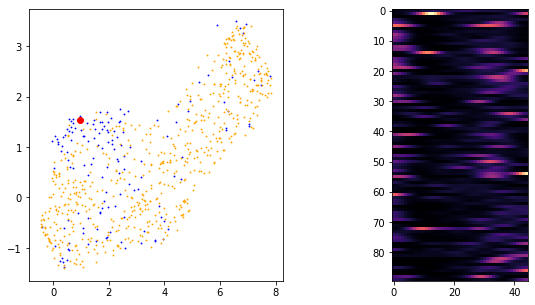

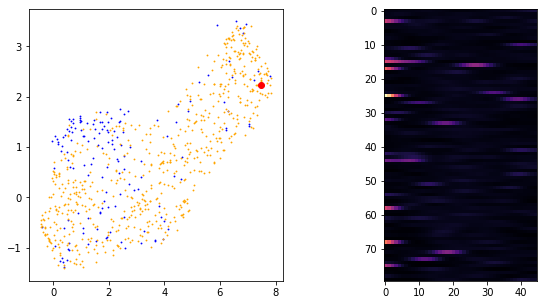

In [82]:
# init cache 
%matplotlib inline
for c in [0]: #,1]:
    for subclust_ind in range(1): #10):
#         f,ax = plt.subplots(1,10,figsize=[15,5])
        embedding = clust_results[c]['subclust_'+str(subclust_ind)]['mapper_vis'].embedding_
        subclust_rfl = rfl[clust_results[c]['clustmask']]
        subclust_rfl = subclust_rfl[clust_results[c]['subclust_labels']==subclust_ind]
        
        subclust_sm = sm[clust_results[c]['clustmask']]
        subclust_sm = subclust_sm[clust_results[c]['subclust_labels']==subclust_ind]
        
        subclust_ml = ml[clust_results[c]['clustmask']]
        subclust_ml = subclust_ml[clust_results[c]['subclust_labels']==subclust_ind]
        
        subclust_sessind = sess_ind[clust_results[c]['clustmask']]
        subclust_sessind = subclust_sessind[clust_results[c]['subclust_labels']==subclust_ind]
        
        
#         trialmat_rare,trialmat_freq = subclust_sm[subclust_rfl==0].mean(axis=0).reshape(10,-1)[1:,:],subclust_sm[subclust_rfl==1].mean(axis=0).reshape(10,-1)[1:,:]
#         trialmat_rare_n, trialmat_freq_n = trialmat_rare/np.linalg.norm(trialmat_rare,ord=2,axis=1,keepdims=True),trialmat_freq/np.linalg.norm(trialmat_freq,ord=2,axis=1,keepdims=True)
#         ax[1].imshow(trialmat_rare,aspect='auto',cmap='magma')
#         ax[2].imshow(np.dot(trialmat_rare_n,trialmat_rare_n.T),cmap='cividis')
#         ax[3].imshow(trialmat_freq,aspect='auto',cmap='magma')
#         ax[4].imshow(np.dot(trialmat_freq_n,trialmat_freq_n.T),cmap='cividis')
            
        # sort cells by both embedding axes
        embdim0_sort, embdim1_sort = np.argsort(embedding[:,0]), np.argsort(embedding[:,1])
        N = embedding.shape[0]
        quartile = int(np.floor(N/4))
        
        # take random 10 cells each from upper and lower quartile each each axis
        randcells = []
        for dim in [0,1]:
            embdim_sort = np.argsort(embedding[:,dim])
            lowquart,highquart = embdim_sort[:quartile], embdim_sort[-quartile:]
            randcells.append(lowquart[np.random.permutation(quartile)[:10]])
            randcells.append(highquart[np.random.permutation(quartile)[:10]])
        randcells = np.unique(np.array(randcells).ravel())
        
        print(randcells,randcells.shape)
        for cell in randcells.tolist():
            # get mouse label
            _ml = int(subclust_ml[cell])
            # get session ind
            _sessind = int(subclust_sessind[cell])
            
            # check for session in cache
            if (_ml,_sessind) not in trial_mat_cache.keys():
                df_mouse = df[df["MouseName"]==mice[_ml]]
                sess = df_mouse.iloc[_sessind]
                with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
                    data = pickle.load(f)
                trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
                S_trial_mat[np.isnan(S_trial_mat)]=0
                S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,3,axis=1)
                S_trial_mat = S_trial_mat[:,:,SIG_CELLS[mice[_ml]][_sessind]]
                trial_mat_cache[(_ml,_sessind)]=S_trial_mat
            else:
                S_trial_mat = trial_mat_cache[(_ml,_sessind)]
            sessmask = (ml==_ml)*(sess_ind==subclust_sessind[cell])
            _S_inds = np.zeros([sessmask.shape[0],])
            _S_inds[sessmask] = np.arange(0,S_trial_mat.shape[2])
            _S_inds = _S_inds[clust_results[c]['clustmask']]
            _S_inds = _S_inds[clust_results[c]['subclust_labels']==subclust_ind]
#             cell_mat = S_trial_mat[:,:,clust_results[c]['clustmask']]
#             cell_mat = cell_mat[:,:,clust_results[c]['subclust_inds']==subclust_ind]
            cell_mat = S_trial_mat[:,:,int(_S_inds[cell])]
                
            # load orig trial matrices
        
            # filter by sig cells - cache matrix for reuse
        
            # filter byclustmask, then subclust mask
            
            f,ax = plt.subplots(1,2,figsize=[10,5])
            # plot embedding and OG trial matrix
            ax[0].scatter(embedding[subclust_rfl==0,0],embedding[subclust_rfl==0,1],c='blue',s=100/rfl.shape[0]**.5)
            ax[0].scatter(embedding[subclust_rfl==1,0],embedding[subclust_rfl==1,1],c='orange',s=100/rfl.shape[0]**.5)
            ax[0].scatter(embedding[cell,0],embedding[cell,1],c='red')
#             ax[0].set_title("clust %i, subclust %i, spatial_pref %f, classification acc %f, pval %f" %(c, subclust_ind,clust_results[c]['subclust_pospref'][subclust_ind],clust_results[c]['subclust_'+str(subclust_ind)]['acc'],clust_results[c]['subclust_'+str(subclust_ind)]['pval']))
            ax[1].imshow(cell_mat,cmap='magma')
                # title with session info and cell ID
        
        
        

# %matplotlib inline
# f,ax = plt.subplots()
# ax.scatter(subclustmapper.embedding_[:,0],subclustmapper.embedding_[:,1],c=subclust_rfl)
# randomcells = np.random.permutation(subclust_sm.shape[0])
# print(randomcells.shape,subclust_sm.shape)
# for cell_ind in range(20):
#     f,ax = plt.subplots(1,2)
#     ax[0].imshow(subclust_sm[randomcells[cell_ind]].reshape(10,-1),cmap='magma',aspect = 'auto')
    
#     ax[0].set_title(mice[int(subclust_ml[randomcells[cell_ind]])])
#     ax[1].scatter(subclustmapper.embedding_[:,0],subclustmapper.embedding_[:,1],c=subclust_rfl)
#     ax[1].scatter(subclustmapper.embedding_[randomcells[cell_ind],0],subclustmapper.embedding_[randomcells[cell_ind],1],c='red')

In [76]:
print(sess_ind.shape,ml.shape)
print(subclust_sessind[cell])
print((sess_ind==5).sum())
print((ml==_ml).sum())
print(_S_inds)

(20712,) (20712,)
5.0
4931
3887
[ 25.  60.  68.  98. 108. 168. 201. 206. 214. 215. 238. 256. 301. 312.
 356. 406. 435. 437. 439. 450. 468. 501. 536. 556. 569. 615. 616. 662.
 669. 682. 703. 713. 714. 719. 726. 727. 735. 746.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.

NameError: name 's' is not defined

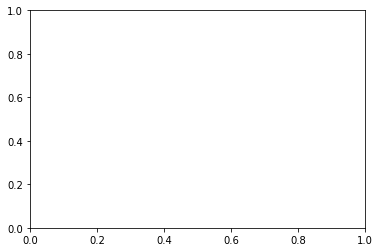

In [45]:
f,ax = plt.subplots()
ax.plot(s[:10])
print(vt.shape)
sf_red = np.dot(np.dot(sf,sf.T),u[:,:2])
f,ax = plt.subplots()
ax.scatter(sf_red[:,0],sf_red[:,1])

f,ax = plt.subplots()
ax.scatter(morphs[morphOrder],vt[0,morphOrder])
ax.scatter(morphs[morphOrder],vt[1,morphOrder])

(10, 10)


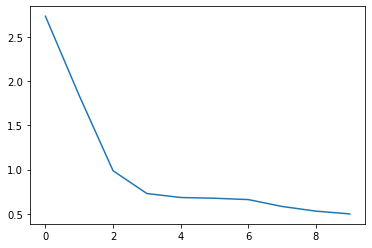

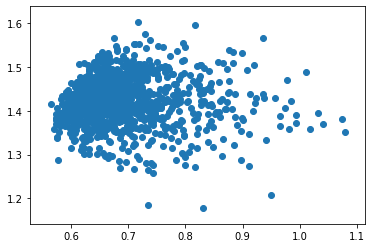

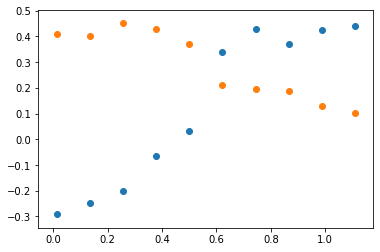

In [95]:
u,s,vt = np.linalg.svd(sf_bin-sf_bin.mean(axis=0,keepdims=True))
f,ax = plt.subplots()
ax.plot(s[:10])
print(vt.shape)
sf_red = np.dot(sf_bin,vt[:2,:].T)
f,ax = plt.subplots()
ax.scatter(sf_red[:,0],sf_red[:,1])

f,ax = plt.subplots()
ax.scatter(edges[1:],vt[0,:])
ax.scatter(edges[1:],vt[1,:])

In [96]:
SimMats = np.matmul(np.transpose(S_trial_mat,axes=(2,0,1)),np.transpose(S_trial_mat,axes=(2,1,0)))

In [97]:
print(SimMats.shape)

(1194, 100, 100)


In [98]:
# morphs = wallmorphx(trial_info['morphs']+trial_info['wallJitter'])
SM_bin = np.zeros((SimMats.shape[0],10,10))
rowmask = np.ones([SimMats.shape[0],1,1])>0
for i in range(10):
    mask_i = np.array(morphdig==i)[:,np.newaxis]
    for j in range(10):
        mask_j = np.array(morphdig==j)[np.newaxis,:]
        
        SM_bin[:,i,j]= SimMats[:,mask_i*mask_j].mean()

        
        

SimMats = SimMats[:,morphOrder,:]
SimMats=SimMats[:,:,morphOrder]

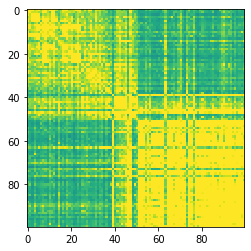

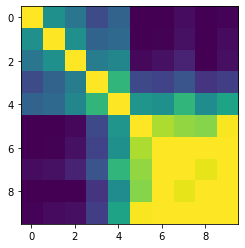

In [99]:
f,ax = plt.subplots()
ax.imshow(SimMats.mean(axis=0),vmax = np.percentile(SimMats,80),vmin=np.percentile(SimMats,10))
f,ax = plt.subplots()
ax.imshow(SM_bin.mean(axis=0),vmax = np.percentile(SM_bin,80),vmin=np.percentile(SM_bin,10))

In [114]:
SM_bin_flat = SM_bin.reshape(SM_bin.shape[0],-1)
u,s,vt = np.linalg.svd(SM_bin_flat-SM_bin_flat.mean(axis=1,keepdims=True))

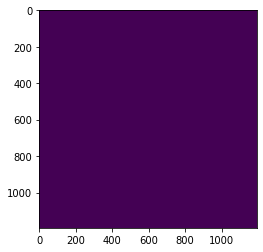

In [117]:
f,ax = plt.subplots()
ax.imshow(np.dot(SM_bin_flat-SM_bin_flat.mean(axis=1,keepdims=True),(SM_bin_flat-SM_bin_flat.mean(axis=1,keepdims=True)).T))

(100, 100)


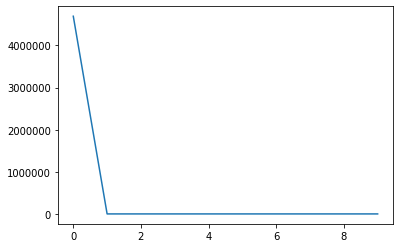

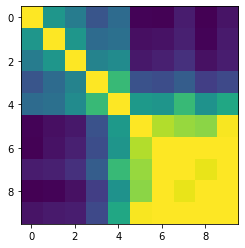

In [115]:
f,ax = plt.subplots()
ax.plot(s[:10])
print(vt.shape)
# SM_bin_red=np.matmul(SM_bin_flat,vt[:1,:].T)
f,ax = plt.subplots()
ax.imshow(-1*vt[0,:].reshape(*SM_bin.shape[1:]),vmax=np.percentile(-vt[0,:],80))

In [76]:
triu_inds = np.triu_indices_from(np.squeeze(SM_bin[0,:,:]))

In [77]:
SM_triu = SM_bin[:,triu_inds[0],triu_inds[1]]

In [103]:
print(np.amax(SM_triu))

0.27333464808831837


In [120]:
u,s,vt = sp.linalg.svd(SM_bin.reshape(SM_bin.shape[0],-1))

[[-0.12446383 -0.09515413 -0.0956459  -0.09160617 -0.08094065 -0.0824731
  -0.08272783 -0.08411843 -0.08368091 -0.08236668 -0.09515413 -0.13232054
  -0.09608135 -0.09280688 -0.08242893 -0.08400031 -0.08420347 -0.08573929
  -0.08489045 -0.08384771 -0.0956459  -0.09608135 -0.14342199 -0.09598295
  -0.08489957 -0.0863117  -0.08681669 -0.08858213 -0.0875513  -0.086407
  -0.09160617 -0.09280688 -0.09598295 -0.14711452 -0.08404241 -0.08623056
  -0.08599448 -0.08750419 -0.08685743 -0.08581498 -0.08094065 -0.08242893
  -0.08489957 -0.08404241 -0.14766368 -0.10134546 -0.10205362 -0.10665281
  -0.10448803 -0.10283116 -0.0824731  -0.08400031 -0.0863117  -0.08623056
  -0.10134546 -0.15097117 -0.10384106 -0.10756991 -0.10561807 -0.10514459
  -0.08272783 -0.08420347 -0.08681669 -0.08599448 -0.10205362 -0.10384106
  -0.15851259 -0.10994426 -0.10733238 -0.10553463 -0.08411843 -0.08573929
  -0.08858213 -0.08750419 -0.10665281 -0.10756991 -0.10994426 -0.1566152
  -0.11230553 -0.10945747 -0.08368091 -0.0

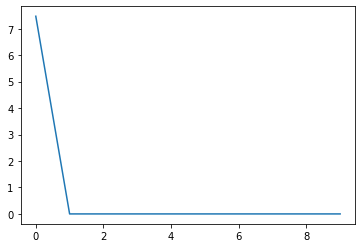

In [121]:
f,ax = plt.subplots()
ax.plot(s[:10]**.5)
print(vt[:1,:])